# Changepoint analysis

The basic problem here is that we want to know whether works of music and literature changed more rapidly in some periods of history than in others. 

Defining "cultural change" is not of course a purely quantitative problem. But it's worth starting with a simple approach, to see what we find. If simple measures of similarity between works do reveal significant periods of acceleration, that would be interesting -- even if it's not the only kind of change that matters.

So let's provisionally define the distance between two works (songs or novels) as cosine distance between two vectors. In the case of a novel, the components of a vector might represent word frequencies, or topic frequencies. In the case of a song, they're going to represent the proportion of the song assigned to one of fourteen primary components inferred by Mauch et al. in [The Evolution of Popular Music](http://rsos.royalsocietypublishing.org/content/2/5/150081).

I'm using the Mauch et al. dataset as a test case. I'm not actually interested in making claims about the history of music, and I cannot know whether their dimension-reduction of music (using LDA and PCA) is reliable. But it's a large and well-organized dataset that I can use to develop ways of measuring historical change before I move on to my own (literary) data. Mauch and his coauthors have already identified three significant "revolutions" in the music data, which they date to specific years, but [I'm skeptical about their assessment of statistical significance.](http://tedunderwood.com/2015/10/03/can-we-date-revolutions-in-the-history-of-literature-and-music/) (I believe the method they used is likely to produce p < 0.05 for *any* year in a historically-sequential time series.)

Let's try a different approach, using changepoint detection. We'll start by importing some useful modules, and loading the music data. The timeline is 200 quarter-year periods between 1960 and 2010. Each row of the data file represents a single song, and the variables we want are principal components in columns labeled PC1 to PC14. We're going to turn each song into a numpy vector, and aggregate the songs for each quarter in a dictionary where they can be recalled by "quarter numbers" that range from 0 to 199.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv, os, random
import numpy as np
from collections import Counter
from scipy import spatial

songsbyquarter = dict()

numfields = 14
fieldnames = []
for i in range(14):
    fieldnames.append('PC' + str(i+1))

maxquarter = 0

with open('EvolutionPopUSA_MainData.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        dateparts = row['quarter'].split(' Q')
        year = int(dateparts[0])
        quarter = int(dateparts[1])
        quarter = (((year - 1960) * 4) + quarter) - 1

        if quarter > maxquarter:
            maxquarter = quarter
        
        thisvector = np.zeros(14)
        for i in range(14):
            thisvector[i] = float(row[fieldnames[i]])

        if quarter not in songsbyquarter:
            songsbyquarter[quarter] = []
        songsbyquarter[quarter].append(thisvector)

print(maxquarter)

199


Ideally, the number of songs would be constant across the timeline. Otherwise we might run into unequal variance. In the music dataset, this is a significant issue.

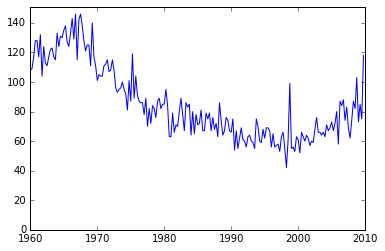

In [3]:
def display_count(songsbyquarter):
    sequential_numbers = []
    for i in range(200):
        sequential_numbers.append(len(songsbyquarter[i]))
    
    ax = plt.axes()
    ax.set_ylim(0, max(sequential_numbers) + 5)
    xvals = [1960 + x/4 for x in range(200)]
    plt.plot(xvals, sequential_numbers)
    plt.show()
    
display_count(songsbyquarter)

Let's create a more even distribution by randomly selecting 75 songs per quarter. This won't produce a perfectly even distribution, but I believe it's close enough not to make a big difference.

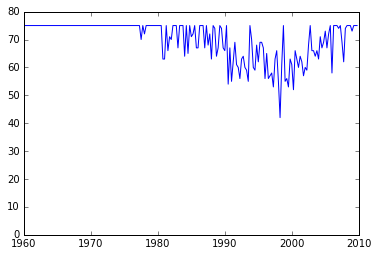

In [4]:
songsample = dict()

for i in range(200):
    
    if len(songsbyquarter[i]) < 75:
        n = len(songsbyquarter[i])
    else:
        n = 75
        
    songsample[i] = random.sample(songsbyquarter[i], n)
    
display_count(songsample)

Good enough. In principle, the dip that remains could make change seem more rapid around 2000 (since smaller samples could be more volatile). So we should be skeptical of any signal to that effect. (In practice, I don't think we'll see that sort of signal.)

Now, how to assess the pace of change? 

A simple way is to compare the mean vectors for adjacent segments of the timeline.
Let's define a function.

In [5]:
import csv

with open('randomsubset.csv', mode='w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['quarternumber']
    header.extend(fieldnames)
    writer.writerow(header)
    for i in range(200):
        s = songsample[i]
        for song in s:
            outrow = [i]
            outrow.extend(song)
            writer.writerow(outrow)

In [6]:
def segment_cosine(center, halfwidth, songs):
    ''' Calculates the cosine distance between two segments of
    the timeline -- one of length "halfwidth" before the position
    called "center," and one of length "halfwidth" starting at
    "center." We calculate cosine distance between centroids that
    are simply the mean vector for each segment.
    '''
    global numfields
    
    oldvec = np.zeros(numfields)
    newvec = np.zeros(numfields)
    
    for i in range(center - halfwidth, center):
        if i in songs:
            for song in songs[i]:
                oldvec += song

    for i in range(center, center + halfwidth):
        if i in songs:
            for song in songs[i]:
                newvec += song

    dist = spatial.distance.cosine(oldvec, newvec)

    return dist

Now we can straightforwardly plot the pace of change by comparing, say, the first half of each year (2 quarters) to the next.

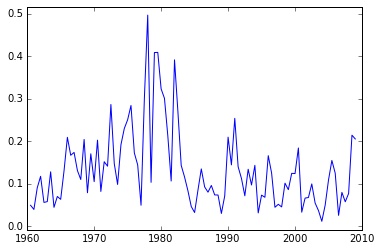

1978.0


In [7]:
def get_distance(interval, centroids):
    ''' Calculates the cosine distances between non-overlapping
    segments of "interval" width. It also prints out the year where
    distance is at a maximum.
    '''
    distances = []
    years = []
    for i in range(interval, 200 - interval, interval):
        thisdist = segment_cosine(i, interval, centroids)
        distances.append(thisdist)
        years.append(1960 + i / 4)

    return years, distances

def plot_timeseries(twotuple):
    years, distances = twotuple
    ax = plt.axes()
    ax.set_ylim(min(distances) - 0.02, max(distances) + 0.02)
    plt.plot(years, distances)
    plt.show()
    print(years[distances.index(max(distances))])

plot_timeseries(get_distance(2, songsample))


The peaks here represent periods of rapid change *within* a year -- places where the centroid for the first half of the year was very different from the centroid for the second.

Now, of course we don't know that these changes continue *in the same direction.* Maybe periods of "rapid change" here are just periods where spring and summer was very different from fall and winter. The "rapid change" could just be rapid motion back and forth.

We can test this by using larger windows. For instance, what happens if we compare change year-over-year, or compare the previous two years to the next two years?

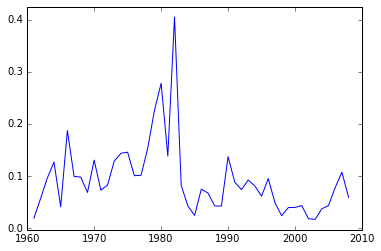

1982.0


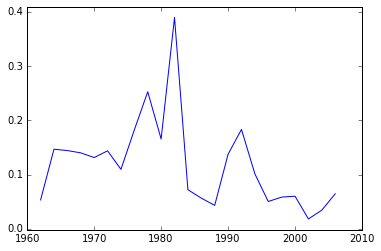

1982.0


In [8]:
x = plot_timeseries(get_distance(4, songsample))
x = plot_timeseries(get_distance(8, songsample))

This is semi-reassuring. Periods where short-term differences are substantial mostly seem to be the same periods where difference is substantial over longer windows. So we're probably not seeing simple oscillation; there's some reason to think that short-term and long-term change correlate. (However, the arbitrariness of these windows is a basic problem. This is a place where I'd love to use a more elegant method if one is available. At the end of the notebook I discuss some possibilities.)

The results we're seeing *loosely* but only loosely conform to the results in the original article, where 1964, 1991, and especially 1983 were points of particularly rapid change.

But a more fundamental problem remains: we have no way of knowing whether the differences of rate between different periods are *significant.* The distance between 1981 and 1982 may be six or seven times the distance between 1986 and 1987. But is that difference significant, or could a variation of that magnitude occur randomly?

Normally I'd try a permutation test by shuffling songs and re-running the comparison. But that doesn't make sense here. The sequential ordering of songs is not an accidental feature of the dataset. We have very strong reason to expect that songs near each other on the timeline will be more similar than those far apart. So if we randomize placement on the timeline, we'll get distances between years that bear no relation at all to the distances you would see in any historical sequence.

However, changepoint analysis offers a solution. We can calculate changes on some fairly short window (say, year-to-year) and then use a cumulative summing technique to identify periods where those year-to-year distances tend to be consistently above or below average for the whole timeline. As long as the individual year-to-year distances are independent of each other, we can meaningfully test the statistical significance of these *periods of sustained change* by permuting, not the underlying songs, but the *distance* measurements.

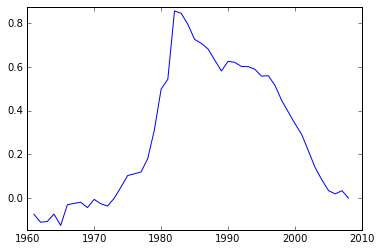

1982.0


In [9]:
def cumulative_sum(twotuple):
    ''' Returns a cumulative running sum of differences from the mean.
    '''
    
    years, distances = twotuple
    meandist = sum(distances) / len(distances)
    
    cs = []
    seqlen = len(distances)
    
    for i in range(seqlen):
        if len(cs) > 0:
            oldcs = cs[i-1]
        else:
            oldcs = 0
            
        newcs = oldcs + (distances[i] - meandist)
        cs.append(newcs)
    
    assert len(cs) == len(years)
    
    return years, cs

plot_timeseries(cumulative_sum(get_distance(4,songsample)))       
    

The cumulative sum plot is not very easy to read. Peaks now represent years *at the end* of a period of rapid change; rapider-than-normal change is indicated by a rising slope. Slower-than-normal change is a declining slope. The real point of the cumulative sum technique is that it allows us to run a significance test. If we randomly permuted the underlying year-to-year distances, how likely would we be to see graphs that span a vertical distance equal to the distance shown above between highest peak and deepest valley?

A lot of what I do here is guided by [Wayne Taylor's discussion of changepoint analysis.](http://www.variation.com/cpa/tech/changepoint.html)

In [10]:
def permute_test(distances, value_to_test):
    ''' Runs 1000 random permutations, to assess how often random sequences
    produce a cumulative sum graph that varies as much as the actual one.
    '''
    peaktovalley = []
    years = [0] * len(distances)
    for i in range(1000):
        permuted = random.sample(distances, len(distances))
        years, cumsum = cumulative_sum((years, permuted))
        thisp2v = (max(cumsum) - min(cumsum))
        peaktovalley.append(thisp2v)
    
    peaktovalley.sort(reverse = True)
    
    for idx, value in enumerate(peaktovalley):
        if value_to_test > value:
            break
    
    return (idx / 1000)


We can use the function we just defined to find all the changepoints in the time series. (Remember, we're looking now for points that mark significant divisions in *rates* of change.) The strategy we'll use to find all significant points of change is recursive. Test the whole series for a significant changepoint. If you find one, divide the series into two parts at the changepoint, and test both of the parts for significant changepoints. Keep dividing recursively, stopping when you get a non-significant result or the series is too small to matter. When you run this, you often find a large number of significant changepoints. But remember, you're also running more than one test! We're going to need to compensate for multiple comparisons.

In [41]:
def find_changepoints(years, distances, existing_points):
    years, cumsum = cumulative_sum((years, distances))
    p2v = max(cumsum) - min(cumsum)
    pval = permute_test(distances, p2v)
    
    absolutes = [abs(x) for x in cumsum]
    idx = absolutes.index(max(absolutes))
    
    # Even if this segment of the time series fails to produce a significant
    # changepoint, we record it so we know how many hypotheses
    # we tested.
    
    existing_points.append((pval, years[idx]))
    
    if pval < 0.05:
        # This is a significant changepoint. We now recursively test the
        # halves on either side.
        
        firstyrs = years[0: idx]
        secondyrs = years[idx : len(years)]
        firstdist = distances[0: idx]
        seconddist = distances[idx : len(distances)]
        
        # We only look for more changepoints in sequences that are reasonably
        # long. This is admittedly an arbitrary parameter. Taking it out
        # probably wouldn't change that much.
        
        if len(firstyrs) > 9:
            first_points = find_changepoints(firstyrs, firstdist, [])
        else:
            first_points = []
        
        if len(secondyrs) > 9:
            second_points = find_changepoints(secondyrs, seconddist, [])
        else:
            second_points = []
        
        existing_points.extend(first_points)
        existing_points.extend(second_points)
    
    return existing_points

years, distances = get_distance(8, songsample)
cpoints = find_changepoints(years, distances, [])
cpoints.sort()
print(cpoints)

[(0.003, 1982.0), (0.063, 1974.0), (0.619, 1994.0)]


This is a list of possible changepoints, each of which is represented as a (pvalue, year) tuple. We compensate for multiple comparisons using the Holm-Bonferroni method. Many fewer changepoints are returned.

In [42]:
def holm_bonferroni(testlist):
    ''' Accepts a list of two-tuples, each of which is a pvalue
    and a year. Sorts them and applies the Holm-Bonferroni
    correction for multiple comparisons.
    '''
    
    testlist.sort()
    accepted = []
    m = len(testlist)
    
    for idx, twotuple in enumerate(testlist):
        pvalue, year = twotuple
        threshold = 0.05 / (m + 1 - idx)
        if pvalue > threshold:
            break
        else:
            accepted.append(twotuple)
    
    return accepted

changepoints = holm_bonferroni(cpoints)
print(changepoints)

[(0.003, 1982.0)]


Now we can use those changepoints to divide periods where the pace of change is really *significantly* different. Then we can visualize the mean pace of change for each of those periods. (It would also be nice to have confidence intervals, but this is a first pass.)

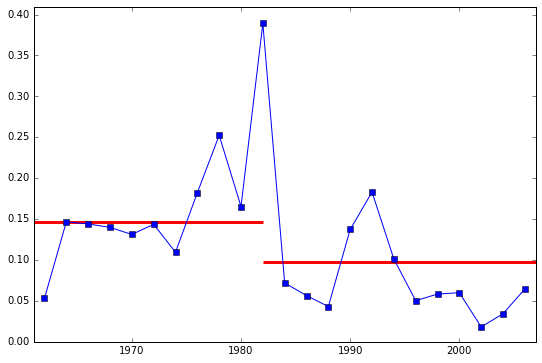

In [43]:
def plot_changepoints(songsample, changepoints, years, distances, overplot):
    plt.rcParams["figure.figsize"] = [9.0, 6.0]
    ax = plt.axes()
    ax.set_ylim(0, max(distances) + 0.02)
    ax.set_xlim(min(years) - 1, max(years) + 1)
    if overplot:
        plt.plot(years, distances, marker = 's')
    else:
        plt.plot(years, distances)
    changepoints.sort(key = lambda x: x[1])
    changepoints.append((0, 2009))
    startpoint = 1960
    changeidx = 0
    for year in range(1960, 2010):
        if year >= changepoints[changeidx][1]:
            changeidx += 1
            endpoint = year
            thisrange = []
            for year, dist in zip(years, distances):
                if year >= startpoint and year < endpoint:
                    thisrange.append(dist)
            thismean = sum(thisrange) / len(thisrange)
            plt.hlines(thismean, startpoint, endpoint, 'r', linewidth = 3)
            startpoint = endpoint
    plt.show()

years, distances = get_distance(8,songsample)
plot_changepoints(songsample, changepoints, years, distances, True)

In [32]:
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)

[6.0, 4.0]


This method suggests that Mauch et al. are over-interpreting their evidence. We cannot really make claims about multiple "revolutions" dated precisely to 1964, 1983, and 1991. According to this graph, there's only one significant change in pace -- a decline from more rapid to less rapid change around 1983.

On the other hand, the arbitrariness of the window we're using for year-to-year comparisons remains basically troubling. Intuitively it's easy to imagine slow changes that would never make much difference on a year-to-year scale, but might be quite dramatic if we compared (say) four-year periods. And there's some evidence that could make a real difference.

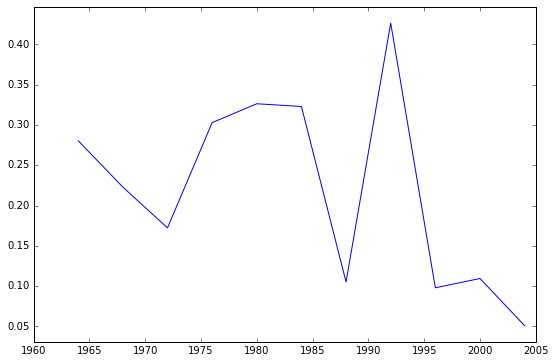

1992.0


In [38]:
x = plot_timeseries(get_distance(16, songsample))

Above, for instance, you see a really different story when we compare distances between the four years immediately before and after various points on the timeline. 1992 is now the most significant point of change. But when I analyze the time series on this scale, it's difficult to make any claims about statistical significance, because we don't have enough observations to use a "cumulative sum" technique.

There are two separate problems here:

1. The arbitrariness of window width.
2. The problem that wide windows don't give you enough observations to test for significance.

The first one, I think, is just a basic problem that's hard to get around. The best solution I can see is just to use visualizations that reveal multiple scales. The authors of "The Evolution of Popular Music" have [one nice way to visualize multiple scales of comparison at once,](http://tedunderwood.com/2015/10/03/can-we-date-revolutions-in-the-history-of-literature-and-music/) by creating a distance matrix of all segments against all segments.


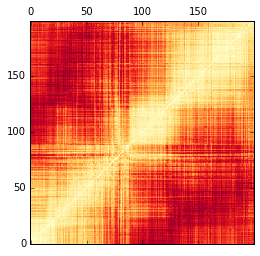

In [15]:
def distance_matrix(songs, maxquarter, numfields):
    observations = maxquarter + 1
    distmat = np.zeros((observations, observations))
    for i in range(observations):
        for j in range(observations):
            icentroid = np.zeros(numfields)
            jcentroid = np.zeros(numfields)
            for song in songs[i]:
                icentroid += song
            for song in songs[j]:
                jcentroid += song
            dist = spatial.distance.cosine(icentroid, jcentroid)
            distmat[i, j] = dist
    return distmat

d = distance_matrix(songsbyquarter, maxquarter, numfields)
plt.matshow(d, origin = 'lower', cmap = plt.cm.YlOrRd)
plt.show()

This is a great visualization, revealing similarity and difference on many different scales. The diagonal line here is basically the timeline, and yellow "squares" are in effect areas of similarity. The "pinch points" between squares are places where change is relatively rapid.

However, this visualization by itself is not a good foundation for claims about effect size or statistical significance. Mauch et al. run a permutation test on it, but it's not very helpful since *all* historically sequential data is going to have that yellow road running diagonally through the middle, and all permuted datasets won't. To infer statistical significance we have to run a permutation on a sequence of *differences,* which means we have to choose a particular window width.

Another possible solution to the arbitrariness of window width would be to run changepoint analysis *directly on the underlying multivariate time series* instead of on measurements of distance between fixed segments. I think there are such techniques. [James and Matteson have an R package ecp](http://arxiv.org/pdf/1309.3295.pdf) that does this. But I notice they say that it makes the assumption "that observations are independent over time," and I don't think I can make that assumption. We know for a fact that songs near each other on the timeline tend to be much more similar than those far apart (because all historical datasets have a "diagonal yellow road").

So, unless there's a cool thing I haven't tried yet, I think problem 1 (arbitrariness of window width) is basically insoluble.

However there are some things we could do to solve problem 2 (the difficulty of testing significance at all on wide windows).


## Take two: gappy distances

<em>Everything below is under erasure, because it involves overlapping windows of comparison, and I'm not sure that it can ever be principled to run a permutation test on values that were produced by overlapping comparisons! I've left the experiment here, though, so you can see what would happen if you did try it.</em>

So far we've been measuring the distances between adjacent segments of the timespan. Two years before Jan 1, 1970 and the two years after. Then, move forward two years, and compare the two years before and after Jan 1, 1972. The problem is that as distances get large, the number of observations decreases. You could just move the centerpoint forward a quarter at a time, from Jan 1, 1970 to Apr 1, 1970, keeping the "windows" two years wide -- but the problem with that idea is, adjacent observations would no longer be independent because the windows being compared would now overlap. A permutation test would no longer be a reliable way of testing the cumulative sum, because you'd be comparing apples (autocorrelated comparisons) and oranges (a really random series).

But what if we eliminated that problem by measuring the distance between *pairs of quarters separated by a gap.* In other words, we'll compare Oct 1, 1967 - Dec 31, 1967 to Jan 1, 1972 - Mar 31, 1972. Then we can still move forward a quarter at a time without (at least, I *think* without) necessarily destroying the independence of adjacent observations. In practice, adjacent observations will still tend to be similar. But that's only true *because* the changes inside that "gap" are really more rapid in some periods than in other periods. So we can still use a permutation test; the test won't be merely revealing the autocorrelation of the original time series, but the fact that *paces of change* are correlated (which is in fact the claim that we're seeking to test). I'm explaining this at length because I'm honestly still a little uncertain about it. It's true that sequential "gaps" will overlap. I *think* that's less problematic than overlaps in the actual segments-compared, but I want to hear what y'all have to say.

[(0.0, 1984.0), (0.0, 1989.5), (0.0, 1995.0), (0.001, 1972.75), (0.003, 1992.75)]


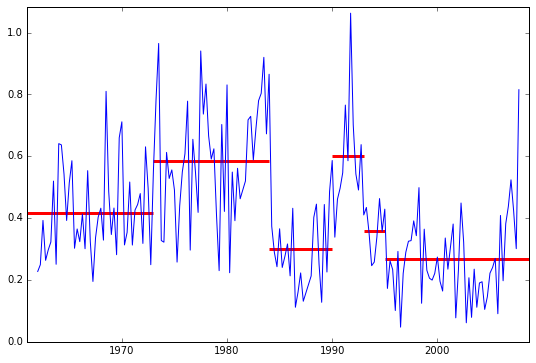

In [44]:
def gappy_cosine(center, halfwidth, songs):
    ''' Calculates the cosine distance between two quarters
    the timeline -- one of length "halfwidth" before the position
    called "center," and one of length "halfwidth" starting at
    "center." We calculate cosine distance between centroids that
    are simply the mean vector for each segment.
    '''
    global numfields
    
    oldvec = np.zeros(numfields)
    newvec = np.zeros(numfields)
    
    for song in songs[center - halfwidth]:
        oldvec += song
        
    for song in songs[center + halfwidth]:
        newvec += song

    dist = spatial.distance.cosine(oldvec, newvec)

    return dist

def gappy_distance(interval, centroids):
    ''' Calculates the cosine distances between quarters
    that are 'interval' quarters from a midpoint. 
    It also prints out the year where distance is at a maximum.
    '''
    distances = []
    years = []
    for i in range(interval, 200 - interval, 1):
        thisdist = gappy_cosine(i, interval, centroids)
        distances.append(thisdist)
        years.append(1960 + i / 4)

    return years, distances

years, distances = gappy_distance(8, songsample)
cpoints = find_changepoints(years, distances, [])
changepoints = holm_bonferroni(cpoints)
print(changepoints)
plot_changepoints(songsample, changepoints, years, distances, False)

with open('fouryeardistances.csv', mode='w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['year', 'distance'])
    for year, distance in zip(years, distances):
        writer.writerow([year, distance])

Not bad. Now we're getting somewhere. This plots the distances between pairs of quarters separated by four years (2 yrs on either side of the midpoint), and then identifies sections of the timeline where sequences of those distances are significantly above or below trend.

But the results we're seeing here are different enough from the year-over-year method that they may just confirm our worry that the width of the "window" you're using is an arbitrary and important parameter. For instance, how much do things change if we look at pairs of quarters separated by six years?

[(0.0, 1990.0), (0.0, 1994.0), (0.003, 1985.0)]


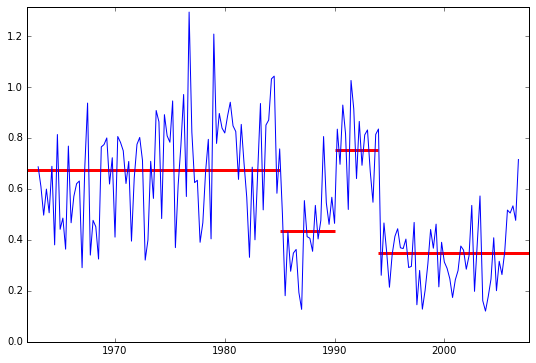

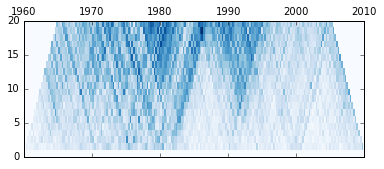

In [45]:
years, distances = gappy_distance(12, songsample)
cpoints = find_changepoints(years, distances, [])
changepoints = holm_bonferroni(cpoints)
print(changepoints)
plot_changepoints(songsample, changepoints, years, distances, False)

distmap = np.zeros((20, maxquarter + 1))
for i in range(1, 20):
    years, distances = gappy_distance(i, songsample)
    for j in range(200 - i*2):
        distmap[i, j + i] = distances[j]

fig = plt.figure(figsize = (6.1,10))
ax = fig.add_subplot(111)
ax.matshow(distmap, origin = 'lower', cmap = 'Blues', extent = [1960,2010,0,20])
plt.show()

Broadly the pattern remains the same, but there are some changes. 

Taking a hint from the Mauch et al. heatmap, I've added a matrix of results using different "gap widths" (in numbers of quarters) to see how volatile or constant the overall pattern is.

The dark areas represent periods of rapid change. And it's pretty clear that there's one of these around 1980, and then another in the early 90s. The exact break locations might depend on the width setting you're using, but the overall pattern is constant. You're only going to see that second period of rapid change (the one in the 1990s) if you use a "gap" setting of two years or more. That's why we missed it using a year-over-year method.

It's also clear that the effect size for these changes is not as dramatic as reported in Mauch et al. They say that the pace of change at the "peak" of a revolution is four to six times the pace in a trough. That's true only if we're comfortable reporting isolated data points where p >> 0.05. If we're talking about *significant* differences, we can only say that there are periods of rapid change with a pace maybe 1.5 times the mean, or twice as rapid as the periods of slowest change. That's still interesting, but it's definitely not the story punctuated by sudden, brief "revolutions" that gets told in "The Evolution of Popular Music."

###### FIN.